In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from IPython.display import clear_output

import pandas as pd

log = pd.read_csv('logs.csv')
genres = pd.read_csv('genres.csv')
movies = pd.read_csv('movies.csv')
staff = pd.read_csv('staff.csv')
countries = pd.read_csv('countries.csv')

movies['genres'] = movies['genres'].apply(eval)
movies['countries'] = movies['countries'].apply(eval)
movies['staff'] = movies['staff'].apply(eval)

def MAP(true, pred):
    AP_list = []
    for true_values, pred_values in zip(true, pred):
        P = 0
        W_list = []
        for N, pred_movie_id in enumerate(pred_values):
            if pred_movie_id in true_values:
                P += 1
                R = 1
                W_list.append(P/(N+1)*R)
            else:
                P += 0
                R = 0
                W_list.append(P/(N+1)*R)
        AP_list.append(sum(W_list)/len(W_list))
    return sum(AP_list)/len(AP_list)

# Примитивная модель V0

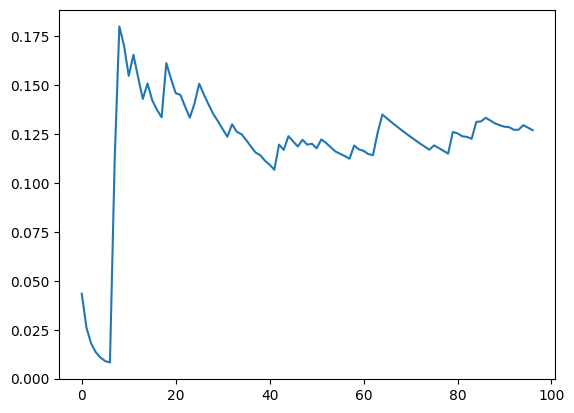

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:15<00:00,  1.96s/it]

Final result:  0.12698075549105026


In [203]:
def get_best(df, value_list):
    best_df = df.loc[df['id'].apply(lambda id: True if id in value_list else False)]
    best_df.loc[:, 'count'] = [value_list.count(id) for id in best_df['id']]
    best_df = best_df.sort_values(by='count', ascending=True)
    return best_df

train = log.loc[round(len(log)*0.7):, :]
test = log.loc[:round(len(log)*0.7), :]

pred_list, true_list = [], []
results = []
n_records = 100
for test_id in tqdm(train.iloc[:n_records, 2].tolist(), total=n_records):
    if test_id not in test['user_id'].tolist():
        pass
    else:
        user_movies_id = train.loc[train['user_id']==test_id, 'movie_id'].tolist()
        user_movies = movies[movies['id'].apply(lambda m_id: True if m_id in user_movies_id else False)]
        
        get_list = lambda lists: [item for sublist in lists.tolist() for item in sublist]
        user_genres = get_list(user_movies['genres'])
        user_countries = get_list(user_movies['countries'])
        user_staff = get_list(user_movies['staff'])
        
        movies['matches']=[0 for _ in range(len(movies))]
        for index, mg in movies['genres'].items():
            movies.loc[index, 'matches']+=sum([1 if id in user_genres else 0 for id in mg])
        
        for index, mc in movies['countries'].items():
            movies.loc[index, 'matches']+=sum([1 if id in user_countries else 0 for id in mc])
        
        for index, ms in movies['staff'].items():
            movies.loc[index, 'matches']+=sum([1 if id in user_staff else 0 for id in ms])
        
        pred_list.append(movies.loc[movies['matches']>np.mean(list(set(movies['matches'])))].sort_values(by='matches', ascending=False)['id'].tolist())
        true_list.append(test.loc[test['user_id'] == test_id, 'movie_id'].astype(int).tolist())
        results.append(MAP(pred_list, true_list))
        plt.plot(np.arange(len(results)), results)
        clear_output(wait=True)
        plt.show()
print('Final result: ', results[-1])

# Модель V0.1

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

In [ ]:
log = pd.read_csv('logs.csv')
genres = pd.read_csv('genres.csv')
movies = pd.read_csv('movies.csv')
staff = pd.read_csv('staff.csv')
countries = pd.read_csv('countries.csv')

In [14]:
test_user_id = 10250
test_user_df = log.loc[log['user_id']==test_user_id]
train, test = train_test_split(test_user_df, test_size=0.2, random_state=42)

print(f"len_df\t\t{len(test_user_df)}\nlen_train\t{len(train)}\nlen_test\t{len(test)}")

len_df		58
len_train	46
len_test	12


In [87]:
test_user_df

,id,datetime,user_id,movie_id,duration
0,0,2023-04-06T15:00:00.071114+03:00,10250,427.0,485.0
2677,2677,2023-04-06T16:27:21.847971+03:00,10250,327.0,5155.0
28979,28979,2023-04-07T09:48:28.824328+03:00,10250,4176.0,2396.0
30038,30038,2023-04-07T10:39:45.946074+03:00,10250,4176.0,2933.0
374249,374249,2023-04-16T01:19:37.694341+03:00,10250,327.0,3.0
374250,374250,2023-04-16T01:19:37.69436+03:00,10250,1785.0,8.0
408116,408116,2023-04-16T20:02:23.184379+03:00,10250,4564.0,11.0
413420,413420,2023-04-16T21:46:58.68754+03:00,10250,4564.0,6205.0
417766,417766,2023-04-16T23:45:31.852647+03:00,10250,4576.0,5727.0
418248,418248,2023-04-17T00:08:37.809029+03:00,10250,5056.0,923.0


In [89]:
movies.loc[movies['id'].apply(lambda id: True if id in test_user_df.movie_id else False)]

,id,name,year,date_publication,description,genres,countries,staff
0,0,"Мама, я дома",2022-01-01,2022-11-23T00:00:00,Где-то в глубинке вместе с дочерью и внуком жи...,[97],[238],"[1883, 33655, 25890, 1001, 12051, 10110, 16895]"
2677,2677,Дневник памяти,2004-01-01,2023-01-12T00:00:00,"Он - деревенский парень, она - красавица из бо...","[138, 97]",[102],"[25488, 5223, 14140, 33559, 29850, 1743, 28953..."


In [81]:
prepare = lambda values, n_features: np.array([1 if av in values else 0 for av in np.arange(0, n_features)])

movie = movies.loc[movies['id']==test_user_df.iloc[0,3]]

# предположим эти числа, возможно впоследствие для ускорения модели нужно будет поменять
prepare(movie.genres.values[0], 500)
prepare(movie.countries.values[0], 500)
prepare(movie.staff.values[0], 500000)


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [50]:
import sklearn.preprocessing as prep
prep.BinaryEncoder().transform([1, 2, 3, 4, 5])

AttributeError: module 'sklearn.preprocessing' has no attribute 'BinaryEncoder'

In [ ]:
# Преобразовываем категориальные данные
label_encoder = LabelEncoder()
df['user_id'] = label_encoder.fit_transform(df['user_id'])
df['movie_id'] = label_encoder.fit_transform(df['movie_id'])

# Разбиваем данные на тренировочный и тестовый наборы
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Масштабируем данные
scaler = StandardScaler()
X_train = scaler.fit_transform(train[['user_id', 'movie_id']])
X_test = scaler.transform(test[['user_id', 'movie_id']])

# Преобразовываем данные в трехмерный массив для входа в LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Создаем модель
model = Sequential()

# Добавляем слой Embedding для обработки категориальных данных
model.add(Embedding(input_dim=len(df['user_id'].unique())+1, output_dim=50, input_length=2))

# Добавляем слой LSTM
model.add(LSTM(units=100, activation='relu'))

# Добавляем выходной слой
model.add(Dense(units=1, activation='sigmoid'))

# Компилируем модель
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Обучаем модель
model.fit(X_train, train['rating'], epochs=10, batch_size=32, validation_split=0.2)

# Оцениваем модель на тестовых данных
accuracy = model.evaluate(X_test, test['rating'])[1]
print(f'Accuracy on test data: {accuracy}')